# “All Press is Good Press?” : Analysis on the Relation Between Subreddit Reviews and Steam Player Counts

#### Team Members: James Clark (JAC692), Alexander Hertadi (AFH78), Katherine O’Conner (KSO25)

### Introduction and Problem Statement:

There is a famous saying “all press is good press”. Is this actually true? The aim of our project is to analyze the association between the sentiment and count of subreddit reviews of a few specific video games and their Steam player counts. We will attempt to measure video game sales via proxy through Steam player counts. There are two overarching goals:

- We want to explore how the play-style design of the game (single-release, single release and DLC content, single-release and updates) correlates to reddit traffic and steam player counts of the games over time.
- We want to explore how negative vs. positive subreddit reviews correlate with Steam player count

With these goals in mind, we chose three games that each represented the play-style designs described above. We also opted for games released in 2016 as the Reddit torrent data is much smaller and more feasible to work with from that time frame. Also, since these games were released so long ago, we are better able to capture play trends and internet traffic patterns of the games over their most relevant timelines. We chose Dark Souls III, No Man’s Sky, and Stardew Valley. From our own background knowledge, No Man’s Sky is infamous for its negative review upon release, yet was still wildly popular.

### Hypothesis:

We expect to find that single release video games will have an initial surge in sales/player count and taper off with time, whereas video games that get patches or additional downloadable content will experience more stable sales/player count. We expect this same trend for the count of subreddit reviews. We expect no strong relationship between time of release and sentiment of reviews.

Generally, we expect the number of Reddit reviews to be the most important predictor of Steam player counts. However, we predict that more positive sentiment reviews will be associated with more stable Steam player counts, whereas more negative sentiment reviews will be associated with sporadic steam player counts and an initial spike upon release.



### Import Statements

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

In [2]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
from google.colab import drive
import os
import json
drive.mount('/content/drive')


os.chdir('/content/drive/MyDrive/Colab_Notebooks')
cwd = os.getcwd()
print(cwd)

# filename = 'filtered_post_combined.jsonl'

# folder_path = '/content/drive/Colab Notebooks/'

# file_path = os.path.join(folder_path, filename)

posts  = pd.read_json('filtered_post_combined.jsonl', lines=True)
# # Specify the path to your JSON file
# filename = 'filtered_comment_combined.jsonl'

# file_path = os.path.join(folder_path, filename)

# # Read the comments JSON file into a DataFrame
comments = pd.read_json('filtered_comment_combined.jsonl', lines=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks


### Load Output Data (Steam Player Counts)

In [4]:
darksouls3_y = pd.read_csv("Daily Dark Souls Player Count.csv").fillna(0)
nomanssky_y = pd.read_csv("Daily No Mans Sky Player Count.csv").fillna(0)
stardewvalley_y = pd.read_csv("Daily Stardew Player Count.csv").fillna(0)

In [5]:
darksouls3_y["DateTime"] = pd.to_datetime(pd.to_datetime(darksouls3_y["DateTime"]).dt.date)
nomanssky_y["DateTime"] = pd.to_datetime(pd.to_datetime(nomanssky_y["DateTime"]).dt.date)
stardewvalley_y["DateTime"] = pd.to_datetime(pd.to_datetime(stardewvalley_y["DateTime"]).dt.date)

<ipython-input-6-4ef1b26cf879>:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  stardew_updates["Date"] = pd.to_datetime(stardew_updates["Date"])


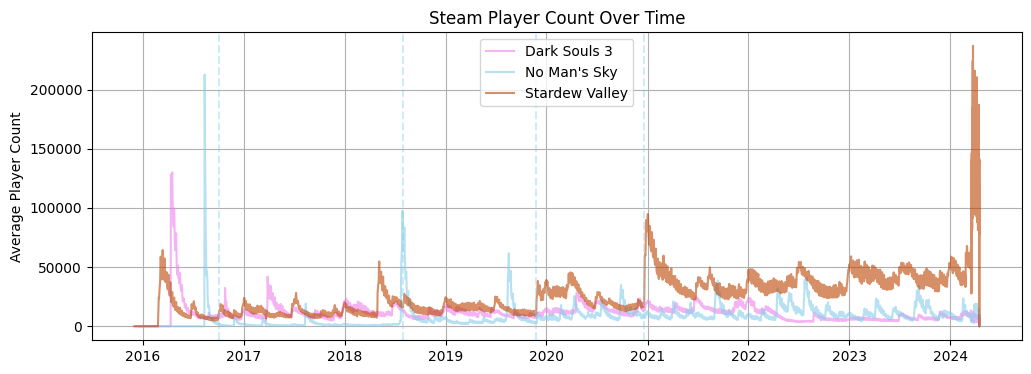

In [6]:
stardew_updates = pd.read_csv("Stardew Updates.csv")
stardew_updates["Date"] = pd.to_datetime(stardew_updates["Date"])

plt.figure(figsize=(12, 4))
games = [darksouls3_y, nomanssky_y, stardewvalley_y]
colors = ["violet", "skyblue", "#bd4404"]
for i in range(3):
    game = games[i]
    plt.plot(game["DateTime"], game["Players"], color = colors[i], alpha=0.6)

for i in range(len(stardew_updates)):
    plt.axvline(x = stardew_updates["Date"][i], linestyle="--", color="skyblue", alpha=0.4)

plt.grid()
plt.title("Steam Player Count Over Time")
plt.ylabel("Average Player Count")
plt.legend(labels=["Dark Souls 3", "No Man's Sky", "Stardew Valley"])
plt.show()

### Loading in, cleaning and calculating sentiment for Posts

In [7]:
posts = pd.read_json('filtered_post_combined.jsonl', lines=True)

posts["created_utc"] = pd.to_datetime(posts["created_utc"], unit='s')
posts = posts.loc[posts['selftext'] != '[removed]']
posts = posts.loc[posts['selftext'] != '[deleted]']
posts = posts.loc[posts['selftext'] != '']
posts = posts.reset_index()

In [8]:
posts

,index,is_self,secure_media,quarantine,thumbnail,from_kind,retrieved_on,author_flair_css_class,secure_media_embed,hide_score,...,spoiler,hidden,brand_safe,suggested_sort,author_cakeday,can_gild,thumbnail_width,thumbnail_height,view_count,is_video
0,0,True,None,False,self,NaN,1454965236,None,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,True,None,False,self,NaN,1454965831,sean,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12,True,None,False,self,NaN,1454966492,None,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,True,None,False,self,NaN,1454966506,DaDa2BbT,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14,True,None,False,self,NaN,1454966540,shipblue,{},False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239026,363221,True,None,False,self,NaN,1497200898,None,{},False,...,0.0,0.0,1.0,None,NaN,NaN,NaN,NaN,NaN,0.0
239027,363222,True,None,False,self,NaN,1497200905,None,{},False,...,0.0,0.0,1.0,None,NaN,NaN,NaN,NaN,NaN,0.0
239028,363223,True,None,False,self,NaN,1497200907,None,{},False,...,0.0,0.0,1.0,None,NaN,NaN,NaN,NaN,NaN,0.0
239029,363225,True,None,False,self,NaN,1497200922,None,{},False,...,0.0,0.0,1.0,None,NaN,NaN,NaN,NaN,NaN,0.0


In [9]:
def get_sentiment(data):
    sia = SentimentIntensityAnalyzer()
    negative = []
    neutral = []
    positive = []
    compound = []
    length = []
    subreddit = []
    for i in tqdm(range(len(data["selftext"]))):
        txt = data["selftext"][i]
        subreddit.append(data["subreddit"][i])
        result = sia.polarity_scores(txt)
        negative.append(result['neg'])
        positive.append(result['pos'])
        neutral.append(result['neu'])
        compound.append(result['compound'])
        length.append(len(txt))

    sentiment_df = pd.DataFrame({"created_utc": list(data["created_utc"]), "subreddit":subreddit,"Text": list(data["selftext"]), "negative": negative, "neutral":neutral, "positive": positive, "compound":compound, "length":length})
    return sentiment_df

p_sentiment = get_sentiment(posts)
p_sentiment.to_csv("sentiment.csv")

p_sentiment = pd.read_csv("sentiment.csv")

100%|██████████| 239031/239031 [05:31<00:00, 722.11it/s]
<ipython-input-9-9ae83e352271>:25: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  p_sentiment = pd.read_csv("sentiment.csv")


In [10]:
posts.columns[posts.isna().mean() < 0.9]


Index(['index', 'is_self', 'quarantine', 'thumbnail', 'retrieved_on',
       'author_flair_css_class', 'secure_media_embed', 'hide_score', 'url',
       'gilded', 'permalink', 'media_embed', 'locked', 'name', 'id',
       'link_flair_text', 'downs', 'num_comments', 'title', 'subreddit', 'ups',
       'stickied', 'score', 'created_utc', 'saved', 'archived', 'edited',
       'author', 'over_18', 'selftext', 'domain', 'author_flair_text',
       'link_flair_css_class', 'subreddit_id', 'preview', 'post_hint',
       'contest_mode', 'spoiler', 'hidden', 'brand_safe'],
      dtype='object')

In [11]:
stardewvalley_posts = posts.loc[posts['subreddit'] == 'StardewValley']
stardewvalley_p_sentiment = p_sentiment.loc[p_sentiment['subreddit'] == 'StardewValley']

nomanssky_posts = posts.loc[posts['subreddit'] == 'NoMansSkyTheGame']
nomanssky_p_sentiment = p_sentiment.loc[p_sentiment['subreddit'] == 'NoMansSkyTheGame']

darksouls3_posts = posts.loc[posts['subreddit'] == 'darksouls3']
darksouls3_p_sentiment = p_sentiment.loc[p_sentiment['subreddit'] == 'darksouls3']

In [12]:
darksouls3_p_sentiment

,Unnamed: 0,created_utc,subreddit,Text,negative,neutral,positive,compound,length
0,0,2016-01-01 00:38:12,darksouls3,I'm not a traditional Souls player. The online...,0.045,0.806,0.149,0.9747,1282.0
2,2,2016-01-01 18:34:10,darksouls3,I must say that the Demon's Souls rolling from...,0.151,0.672,0.177,0.7168,727.0
3,3,2016-01-01 18:42:00,darksouls3,http://imgur.com/a/LUXbT\n\nFound it from this...,0.039,0.875,0.086,0.4155,277.0
5,5,2016-01-01 19:50:23,darksouls3,Maybe it me going crazy and like Caryll divini...,0.114,0.682,0.204,0.8377,455.0
6,6,2016-01-02 02:14:51,darksouls3,Personally I would prefer they do away with po...,0.064,0.936,0.000,-0.2617,182.0
...,...,...,...,...,...,...,...,...,...
239029,239026,2017-05-31 23:27:20,darksouls3,[SotC](https://youtu.be/tfwFyL7l598)\n\nMy bes...,0.000,0.588,0.412,0.6369,66.0
239030,239027,2017-05-31 23:29:39,darksouls3,can someone drop me a lightning urn and a mand...,0.106,0.707,0.187,0.1531,120.0
239031,239028,2017-05-31 23:30:36,darksouls3,Looking for a calculator but failing to find o...,0.368,0.632,0.000,-0.9620,197.0
239032,239029,2017-05-31 23:35:47,darksouls3,I struggled a bit through Dark Souls 1 with th...,0.043,0.772,0.185,0.9904,1289.0


<ipython-input-13-b9083a6b0ace>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['created_utc'] = pd.to_datetime(s['created_utc'])
<ipython-input-13-b9083a6b0ace>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['created_utc'] = pd.to_datetime(s['created_utc'])
<ipython-input-13-b9083a6b0ace>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

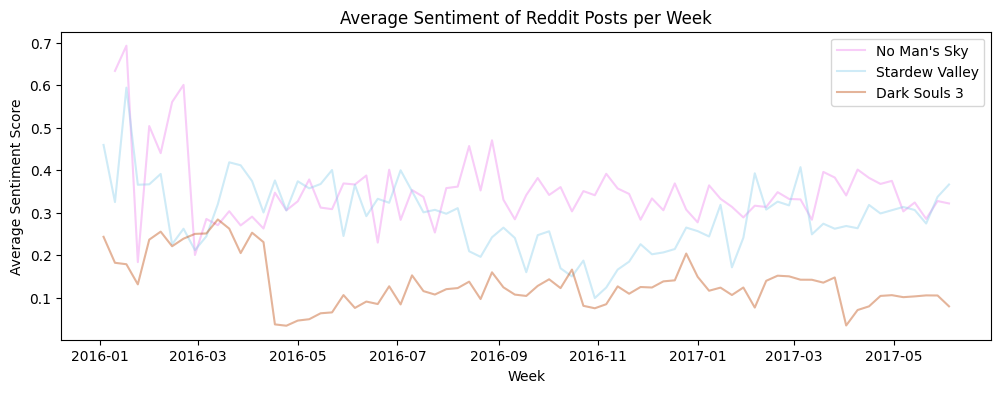

In [13]:
sentiments_list = [stardewvalley_p_sentiment, nomanssky_p_sentiment, darksouls3_p_sentiment]

plt.figure(figsize=(12,4))
for i in range(3):
    s = sentiments_list[i]
    s['created_utc'] = pd.to_datetime(s['created_utc'])
    plt.plot(s.groupby([pd.Grouper(key='created_utc', freq='W')])["compound"].mean(), color=colors[i], alpha=0.4)

plt.xlabel("Week")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment of Reddit Posts per Week")
plt.legend(labels=["No Man's Sky", "Stardew Valley", "Dark Souls 3"])
plt.show()

In [14]:
def clean_input_data(data, sentiment):
    data_group = data.groupby([pd.Grouper(key='created_utc', freq='D')])

    num_posts = data_group["id"].count()
    num_comments = data_group["num_comments"].sum()
    score = data_group["score"].mean()

    sentiment_group = sentiment.groupby([pd.Grouper(key='created_utc', freq='M')])
    sentiment_score = sentiment_group["compound"].mean()
    avg_length = sentiment_group["length"].mean()

    temp_df = pd.DataFrame({"num_posts": num_posts, "num_comments": num_comments, "average_score":score, "sentiment":sentiment_score, "average_length": avg_length})
    temp_df['created_utc'] = pd.to_datetime(temp_df.index)
    temp_df.index = range(len(temp_df))
    temp_df = temp_df.fillna(0)
    # temp_df.index = temp_df.index.to_period('M').to_timestamp()
    return temp_df

stardewvalley_x = clean_input_data(stardewvalley_posts, stardewvalley_p_sentiment)
nomanssky_x = clean_input_data(nomanssky_posts, nomanssky_p_sentiment)
darksouls3_x = clean_input_data(darksouls3_posts, darksouls3_p_sentiment)

stardewvalley_p_data = pd.merge(stardewvalley_x, stardewvalley_y, left_on='created_utc', right_on='DateTime', how="inner")
stardewvalley_p_data = stardewvalley_p_data.drop(columns=["DateTime", "Average Players"])
nomanssky_p_data = pd.merge(nomanssky_x, nomanssky_y, left_on='created_utc', right_on='DateTime', how="inner")
nomanssky_p_data = nomanssky_p_data.drop(columns=["DateTime", "Average Players"])
darksouls3_p_data = pd.merge(darksouls3_x, darksouls3_y, left_on='created_utc', right_on='DateTime', how="inner")
darksouls3_p_data = darksouls3_p_data.drop(columns=["DateTime", "Average Players"])

### Calculating correlations for Posts

Text(0.5, 1.0, 'Stardewvalley Correlation Heatmap')

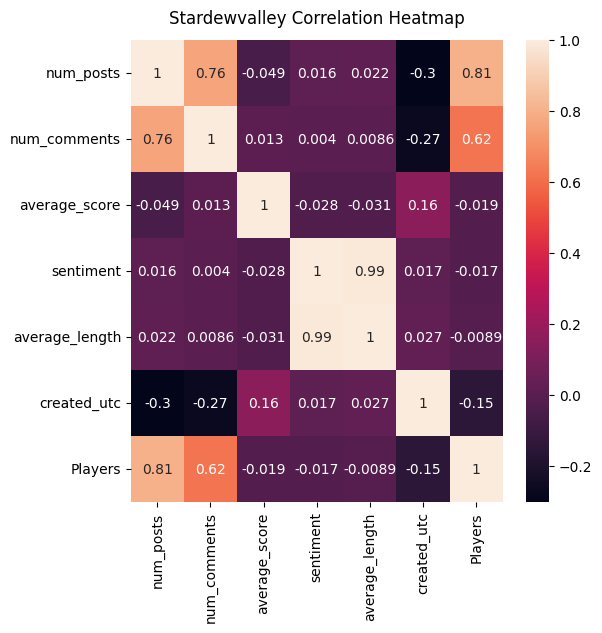

In [15]:
plt.figure(figsize=(6, 6))
stardewvalley_heatmap = sns.heatmap(stardewvalley_p_data.corr(), annot=True)
stardewvalley_heatmap.set_title('Stardewvalley Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Text(0.5, 1.0, 'No Mans Sky Correlation Heatmap')

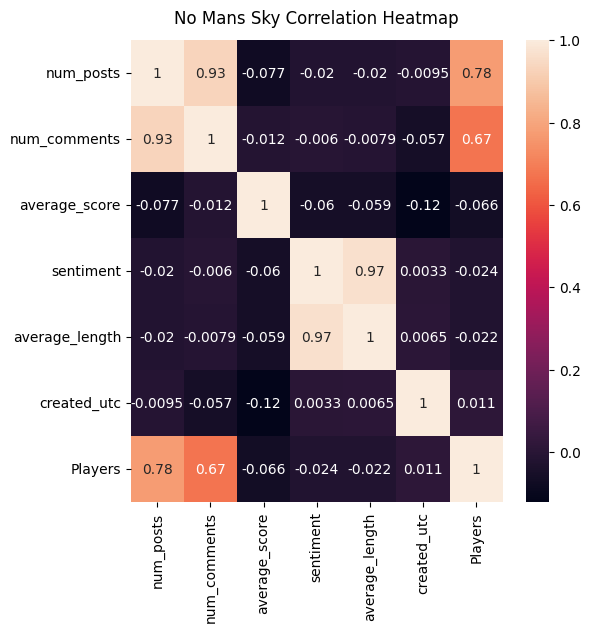

In [16]:
plt.figure(figsize=(6, 6))
no_mans_sky_heatmap = sns.heatmap(nomanssky_p_data.corr(), annot=True)
no_mans_sky_heatmap.set_title('No Mans Sky Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Text(0.5, 1.0, 'Dark Souls 3 Correlation Heatmap')

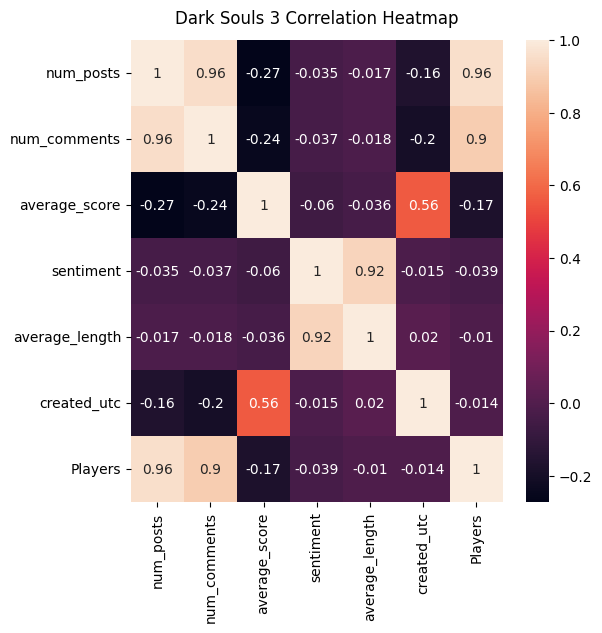

In [17]:
plt.figure(figsize=(6, 6))
darksouls3_heatmap = sns.heatmap(darksouls3_p_data.corr(), annot=True)
darksouls3_heatmap.set_title('Dark Souls 3 Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [18]:
stardewvalley_sentiment = stardewvalley_p_sentiment.reset_index()

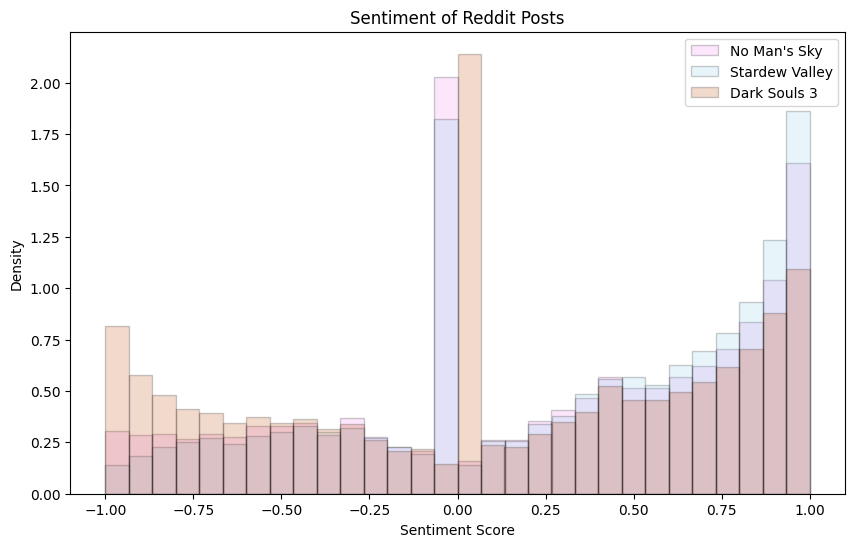

In [19]:
plt.figure(figsize=(10,6))

plt.hist(nomanssky_p_sentiment["compound"], bins=30, color = "violet", ec="black", alpha=0.2, density=True)
plt.hist(stardewvalley_p_sentiment["compound"], bins=30, color = "skyblue", ec="black", alpha=0.2, density=True)
plt.hist(darksouls3_p_sentiment["compound"], bins=30, color = "#bd4404", ec="black", alpha=0.2, density=True)

plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.title("Sentiment of Reddit Posts")
plt.legend(labels=["No Man's Sky", "Stardew Valley", "Dark Souls 3"])
plt.show()


## Modelling daily player counts against Post attributes

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier

import time

In [21]:
default_models = [LinearRegression(), Ridge(), KNeighborsRegressor(), tree.DecisionTreeRegressor(),
                  RandomForestRegressor()]

"""
Attempt various machine learning models and plot predicted values vs. true values of testing data set.
"""
def try_models(model_data, xcols, ycol, models=default_models):

    X = model_data[xcols]
    Y = model_data[ycol]

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # 20-80 train test split data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    results = []
    mses = []

    fig, axs = plt.subplots(1, 5, figsize=(16,3))
    # fig.suptitle(ycol)
    fig.tight_layout(h_pad=5, w_pad=2)
    fig.subplots_adjust(top=0.88)

    for i, model in enumerate(models):
        t1 = time.time()
        model.fit(X_train, Y_train)
        results.append(model)

        # store the predictions for the training and test set
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        # calculate error
                # calculate error
        error = pred_test - Y_test
        mse = round(sum(error**2) / len(error), 2)

        print(model)

        print("Training R^2 :", model.score(X_train, Y_train))
        print("Testing MSE:", mse)

        # print("Test Accuracy: ", accuracy_score(Y_test, pred_test))
        # print("Training Accuracy: ", accuracy_score(Y_train, pred_train))
        r = 0
        c = i
        t2 = time.time()
        print("Time:", t2-t1)
        # axs[r, c].hist(Y_test, alpha=0.6)
        # axs[r, c].hist(pred_test, alpha=0.6)
        axs[c].grid()
        axs[c].scatter(pred_test, Y_test, alpha=0.6)
        axs[c].scatter(pred_train, Y_train, alpha=0.6)
        axs[c].plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], linestyle="--", color="grey")
        axs[c].set_title(str(model) + "\n testing mse: " + str(mse))
        mses.append(mse)
        print()
    plt.savefig('try_models.png')
    plt.show()
    return results, mses

In [22]:
stardewvalley_p_data

,num_posts,num_comments,average_score,sentiment,average_length,created_utc,Players
0,1,34,32.000000,0.00000,0.000000,2016-01-04,1.0
1,1,5,18.000000,0.00000,0.000000,2016-01-05,2.0
2,0,0,0.000000,0.00000,0.000000,2016-01-06,1.0
3,1,20,27.000000,0.00000,0.000000,2016-01-07,3.0
4,0,0,0.000000,0.00000,0.000000,2016-01-08,2.0
...,...,...,...,...,...,...,...
509,12,133,30.250000,0.00000,0.000000,2017-05-27,10114.0
510,10,73,7.400000,0.00000,0.000000,2017-05-28,10590.0
511,22,195,8.318182,0.00000,0.000000,2017-05-29,9828.0
512,17,178,8.647059,0.00000,0.000000,2017-05-30,9030.0


In [23]:
stardewvalley_data_cat = stardewvalley_p_data
stardewvalley_data_cat["subreddit"] = 0
nomanssky_data_cat = nomanssky_p_data
nomanssky_data_cat["subreddit"] = 1
darksouls3_data_cat = darksouls3_p_data
darksouls3_data_cat["subreddit"] = 2
all_p_data = pd.concat([stardewvalley_data_cat, nomanssky_data_cat, darksouls3_data_cat ])
all_p_data["created_utc"] = all_p_data["created_utc"].astype('int64')

Text(0.5, 1.0, 'All Games Correlation Heatmap')

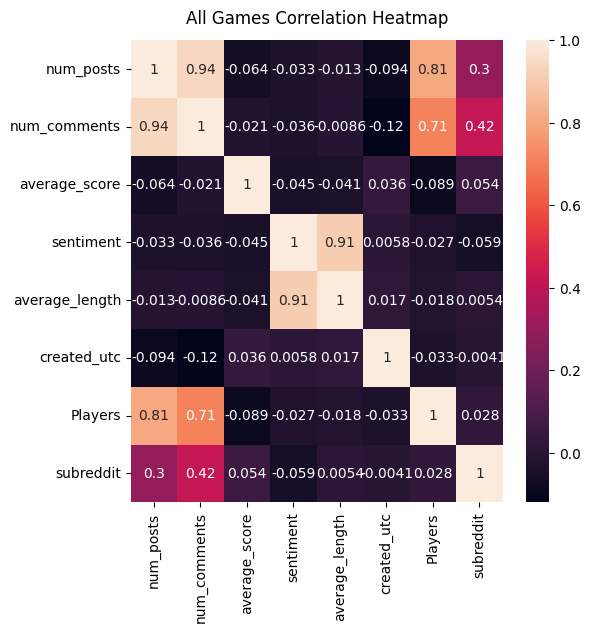

In [24]:
plt.figure(figsize=(6,6))
all_data_heatmap = sns.heatmap(all_p_data.corr(), annot=True)
all_data_heatmap.set_title('All Games Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

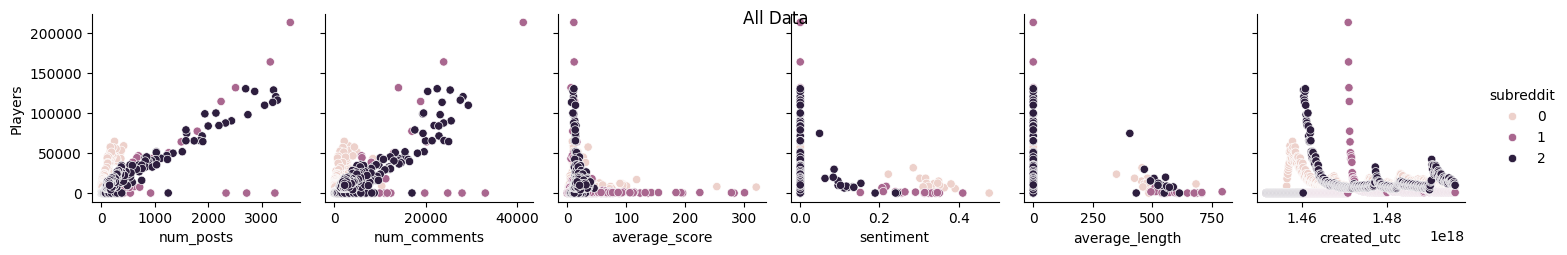

In [25]:
xcols = ['num_posts', 'num_comments', 'average_score', 'sentiment',
       'average_length', 'created_utc']
ycol = 'Players'


sns.pairplot(data = all_p_data, x_vars = xcols, y_vars = ycol, hue="subreddit")
plt.suptitle("All Data")
plt.show()

LinearRegression()
Training R^2 : 0.7022785937847044
Testing MSE: 100810709.25
Time: 0.01376485824584961

Ridge()
Training R^2 : 0.7022648859693061
Testing MSE: 100737385.34
Time: 0.009070873260498047

KNeighborsRegressor()
Training R^2 : 0.8588191517308339
Testing MSE: 73178710.48
Time: 0.03329062461853027

DecisionTreeRegressor()
Training R^2 : 0.9999999999883724
Testing MSE: 112467908.02
Time: 0.01401209831237793

RandomForestRegressor()
Training R^2 : 0.9739379470533958
Testing MSE: 87189708.95
Time: 0.7637715339660645



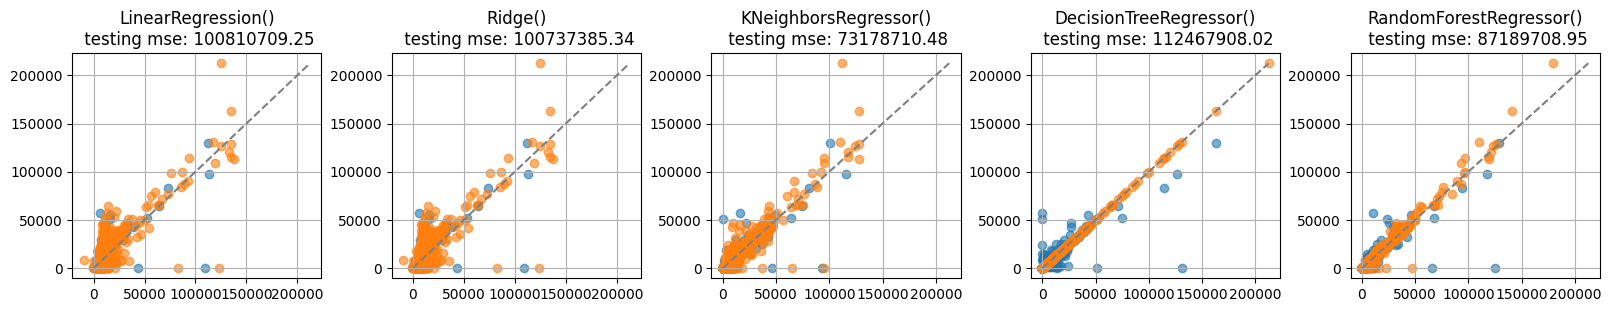

In [26]:
default_models = [LinearRegression(), Ridge(), KNeighborsRegressor(), tree.DecisionTreeRegressor(),
                  RandomForestRegressor()]
feature_importances = []

models, mses = try_models(all_p_data, xcols, ycol, default_models)

feature_importances.append(models[-1].feature_importances_)

LinearRegression()
Training R^2 : 0.6208663147333386
Testing MSE: 59822033.11
Time: 0.00597381591796875

Ridge()
Training R^2 : 0.6208567125855715
Testing MSE: 60296684.11
Time: 0.004966020584106445

KNeighborsRegressor()
Training R^2 : 0.9179522785894282
Testing MSE: 50285631.27
Time: 0.008749246597290039

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 24145282.62
Time: 0.008775949478149414

RandomForestRegressor()
Training R^2 : 0.9885546194710215
Testing MSE: 20793857.06
Time: 0.33254432678222656



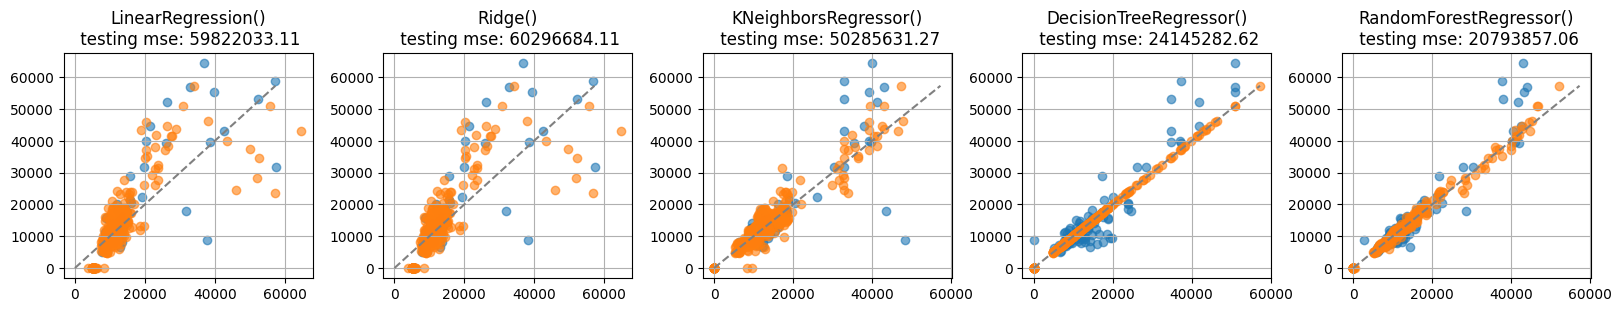

In [27]:
stardewvalley_mod_data = stardewvalley_p_data
stardewvalley_mod_data["created_utc"] = stardewvalley_mod_data["created_utc"].astype('int64')
stardewvalley_models, stardewvalley_mses = try_models(stardewvalley_mod_data, xcols, ycol, default_models)
feature_importances.append(stardewvalley_models[-1].feature_importances_)

LinearRegression()
Training R^2 : 0.662241744438688
Testing MSE: 121233831.96
Time: 0.004125356674194336

Ridge()
Training R^2 : 0.6621082934060023
Testing MSE: 120417376.97
Time: 0.004236459732055664

KNeighborsRegressor()
Training R^2 : 0.5938793537326388
Testing MSE: 80176731.58
Time: 0.0077512264251708984

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 18625921.77
Time: 0.005654096603393555

RandomForestRegressor()
Training R^2 : 0.9314942963961513
Testing MSE: 64230984.07
Time: 0.27722620964050293



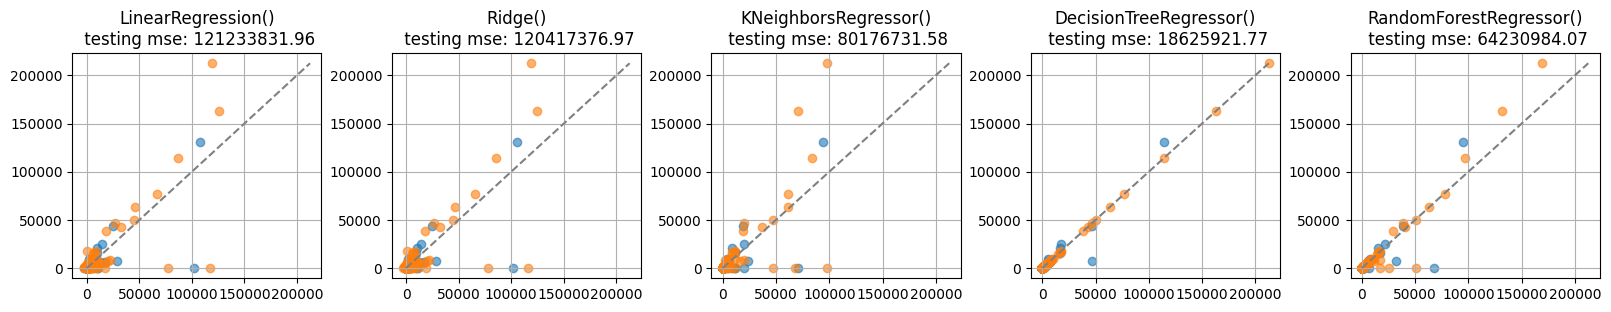

In [28]:
nomanssky_mod_data = nomanssky_p_data
nomanssky_mod_data["created_utc"] = nomanssky_mod_data["created_utc"].astype('int64')
nomanssky_models, nomanssky_mses = try_models(nomanssky_mod_data, xcols, ycol, default_models)
feature_importances.append(nomanssky_models[-1].feature_importances_)

LinearRegression()
Training R^2 : 0.9538117761541675
Testing MSE: 34158437.71
Time: 0.004107952117919922

Ridge()
Training R^2 : 0.9537441433270101
Testing MSE: 34564000.36
Time: 0.005140542984008789

KNeighborsRegressor()
Training R^2 : 0.9692422264026032
Testing MSE: 42561382.03
Time: 0.010315418243408203

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 35304087.45
Time: 0.006247043609619141

RandomForestRegressor()
Training R^2 : 0.9961879082193509
Testing MSE: 45891253.75
Time: 0.2857692241668701



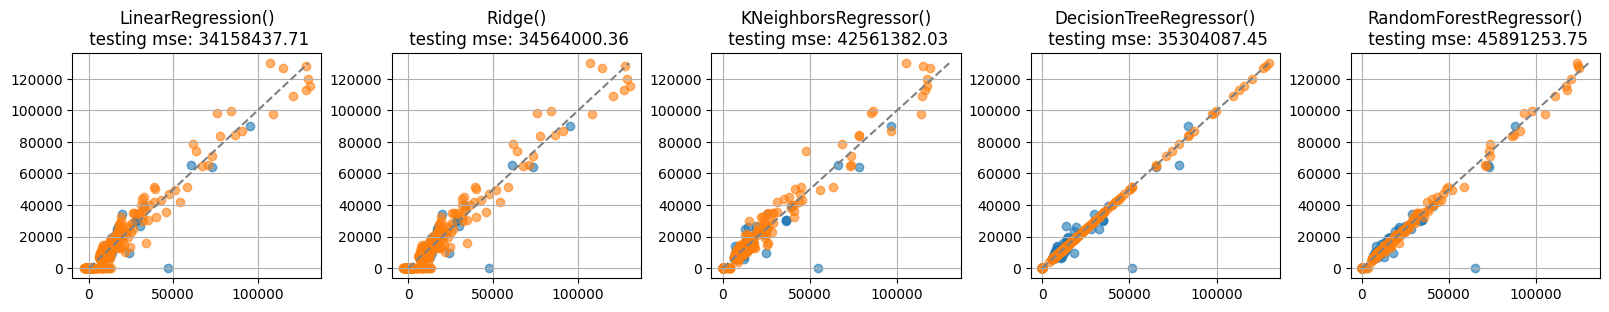

In [29]:
darksouls3_mod_data = darksouls3_p_data
darksouls3_mod_data["created_utc"] = darksouls3_mod_data["created_utc"].astype('int64')
darksouls3_models, darksouls3_mses = try_models(darksouls3_mod_data, xcols, ycol, default_models)
feature_importances.append(darksouls3_models[-1].feature_importances_)

In [30]:
forrest_model = models[-1]

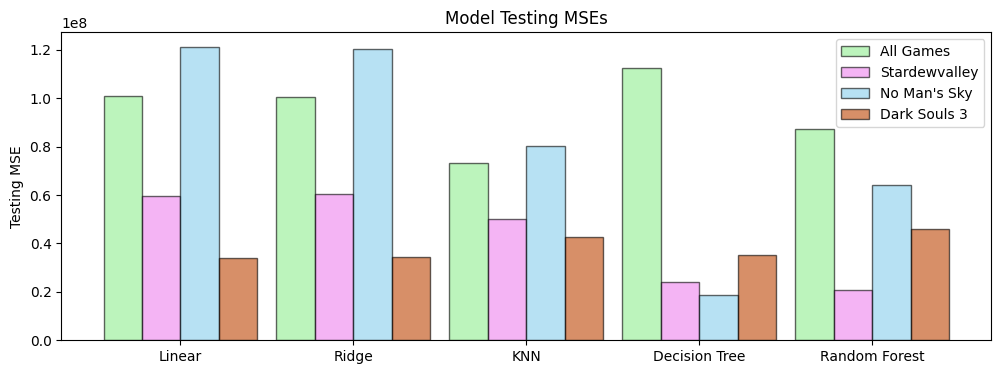

In [31]:
# Define the number of groups and the number of bars within each group
num_groups = 5
num_bars = 4

# Define the width of each bar and the locations of the bars within each group
bar_width = 0.2
group_width = num_bars * bar_width
group_spacing = 0.1
positions = np.arange(num_groups) * (group_width + group_spacing)

fig, ax = plt.subplots(figsize=(12, 4))
colors = ["lightgreen", 'violet', 'skyblue', '#bd4404']

for i, (label, mse) in enumerate(zip(["All Games", "Stardewvalley", "No Man's Sky", "Dark Souls 3"], [mses, stardewvalley_mses, nomanssky_mses, darksouls3_mses])):
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, mse, width=bar_width, label=label, alpha=0.6, color=colors[i], edgecolor="black")


ax.set_xticks(positions + (group_width - bar_width) / 2)
ax.set_xticklabels(["Linear", "Ridge", "KNN", "Decision Tree", "Random Forest"])

plt.ylabel("Testing MSE")
plt.title("Model Testing MSEs")

plt.legend()

plt.show()




### Analysing Random Forest results and feature importance for Posts


In [32]:
def test_model(model_data, xcols, ycol, model, max_depth=None, show=False):
    X = model_data[xcols]
    Y = model_data[ycol]

    # 20-80 train test split data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    t1 = time.time()
    model.fit(X_train, Y_train)

    # store the predictions for the training and test set
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    # calculate error
    error = pred_test - Y_test
    mse = sum(error**2) / len(error)
    test_accuracy = sum(np.round(pred_test) == Y_test) / len(Y_test)
    t2 = time.time()


    if(show):
        print("Testing MSE:", mse)
        print("Time: " + str(t2-t1))
        plt.hist(Y_test, alpha=0.9)
        plt.hist(pred_test, alpha=0.6)
        plt.title(ycol + " " + str(model) + "\n testing mse: " + str(mse) + "\n testing accuracy: " + str(test_accuracy) )
        plt.show()

    return [model, mse, test_accuracy]


def find_best_depth(model_data, xcols, ycol, min_depth = 3 , max_depth = 14, num_trees = 10, title=""):
    t1 = time.time()
    m_mse = []
    all_mse = []
    all_test = []
    for i in tqdm(range(min_depth, max_depth)):
        mses = []
        tests = []
        for j in range(num_trees):
            mResult = test_model(model_data, xcols, ycol, RandomForestRegressor(max_depth=i), show=False)
            mses.append(mResult[1])
            tests.append(mResult[2])
        all_mse.append(mses)
        all_test.append(tests)

    all_mse = np.array(all_mse)
    mean_mses = all_mse.mean(axis=1)
    min_mse = min(mean_mses)

    best_depth1 = min_depth + mean_mses.argmin()

    fig, axs = plt.subplots(1, 1, figsize=(16,5))

    axs.plot(list(range(min_depth, max_depth)), mean_mses)
    axs.fill_between(list(range(min_depth, max_depth)), all_mse.min(axis=1), all_mse.max(axis=1), alpha=0.2)
    axs.scatter(best_depth1, min_mse, color="blue")
    axs.set_xlabel("Tree Depth")
    axs.set_ylabel("Testing MSE")
    axs.set_title("{} (num_trees = {})".format(title, num_trees))

    plt.show()
    print("The best depth is {} with average testing MSE of {}".format(best_depth1, min_mse))
    t2 = time.time()
    print("Computation Time:" + str(t2-t1))

    return best_depth1

100%|██████████| 11/11 [00:51<00:00,  4.69s/it]


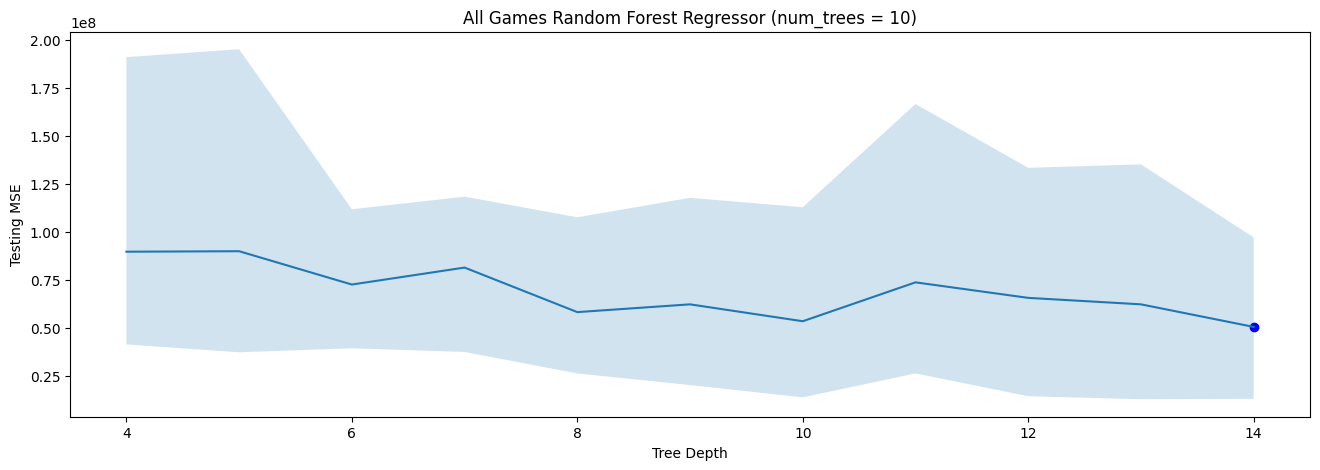

The best depth is 14 with average testing MSE of 50710734.20823873
Computation Time:51.83707594871521


In [33]:
best_depth = find_best_depth(all_p_data, xcols, ycol, min_depth = 4 , max_depth = 15, num_trees = 10, title="All Games Random Forest Regressor")

100%|██████████| 11/11 [00:26<00:00,  2.38s/it]


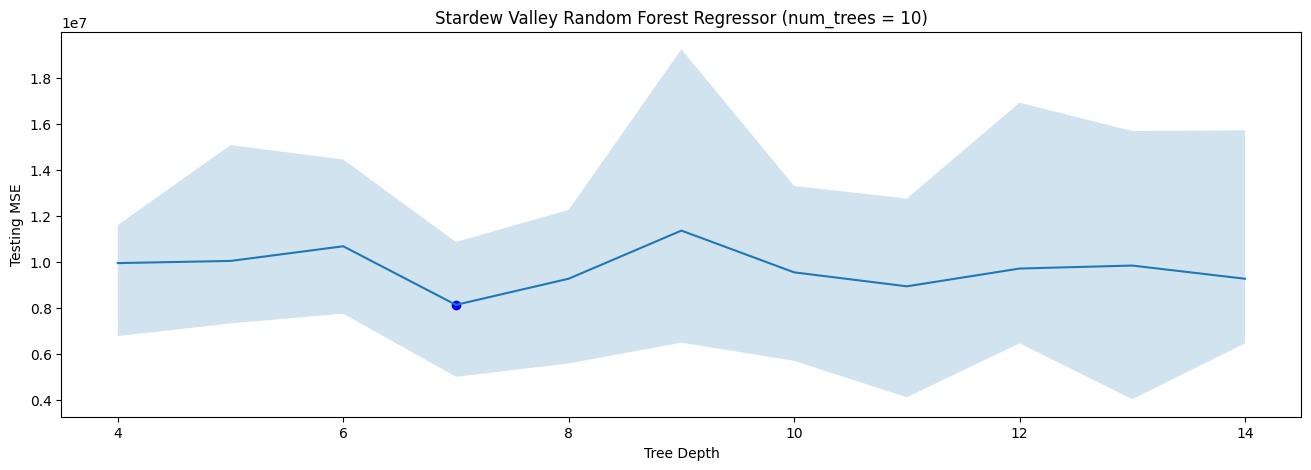

The best depth is 7 with average testing MSE of 8126514.665564234
Computation Time:26.423351764678955


In [34]:
stardewvalley_best_depth = find_best_depth(stardewvalley_p_data, xcols, ycol, min_depth = 4 , max_depth = 15, num_trees = 10, title="Stardew Valley Random Forest Regressor")

100%|██████████| 11/11 [00:27<00:00,  2.46s/it]


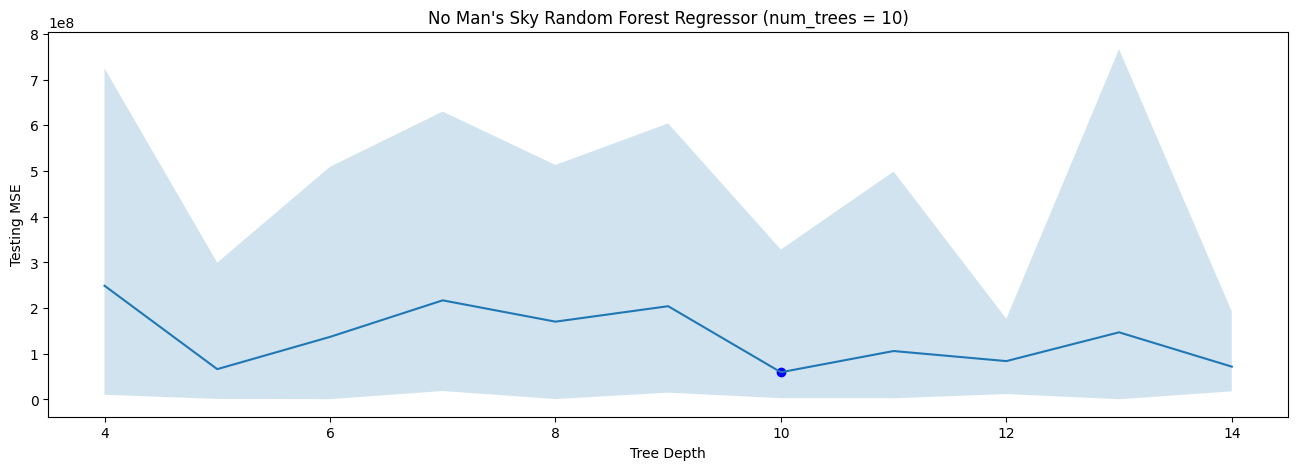

The best depth is 10 with average testing MSE of 59569652.31210597
Computation Time:27.854177236557007


In [35]:
no_mans_sky_best_depth = find_best_depth(nomanssky_p_data, xcols, ycol, min_depth = 4 , max_depth = 15, num_trees = 10, title="No Man's Sky Random Forest Regressor")

100%|██████████| 11/11 [00:40<00:00,  3.66s/it]


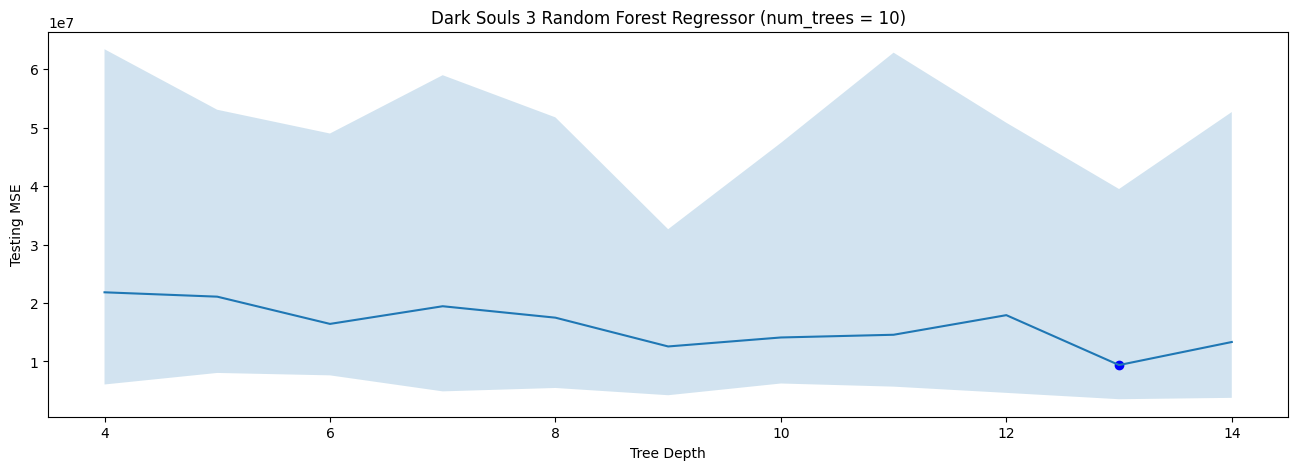

The best depth is 13 with average testing MSE of 9376298.806148386
Computation Time:40.520853757858276


In [36]:
darksouls3_best_depth = find_best_depth(darksouls3_p_data, xcols, ycol, min_depth = 4 , max_depth = 15, num_trees = 10, title="Dark Souls 3 Random Forest Regressor")

In [37]:
all_models = [models[-1], stardewvalley_models[-1], nomanssky_models[-1], darksouls3_models[-1]]
forest_importances = pd.Series(feature_importances[0], index=xcols)
forest_importances

num_posts         0.676614
num_comments      0.115916
average_score     0.063032
sentiment         0.000343
average_length    0.000164
created_utc       0.143931
dtype: float64

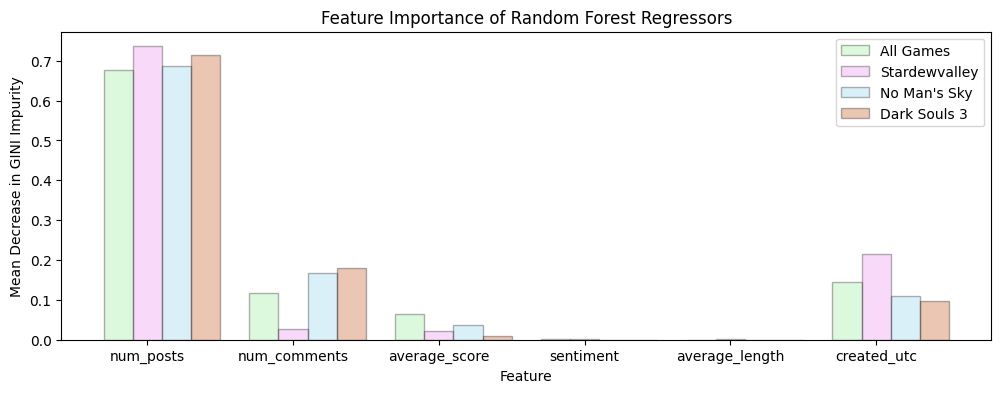

In [38]:
colors = ["lightgreen", 'violet', 'skyblue', '#bd4404']
labels = ["All Games", "Stardewvalley", "No Man's Sky", "Dark Souls 3"]

positions = np.array(list(range(len(xcols))))
bar_width = 0.2
plt.figure(figsize=(12, 4))

for i in range(4):
    plt.bar(positions + bar_width*(i-1), feature_importances[i], width=bar_width, label=label, alpha=0.3, color=colors[i], edgecolor="black")

plt.xticks(positions, labels=xcols)
plt.legend(labels=labels)
plt.xlabel("Feature")
plt.ylabel("Mean Decrease in GINI Impurity")
plt.title("Feature Importance of Random Forest Regressors")
plt.show()

### Loading in, cleaning and calculating sentiment for Comments

In [39]:
comments = pd.read_json('filtered_comment_combined.jsonl', lines=True)

comments["created_utc"] = pd.to_datetime(comments["created_utc"], unit='s')
comments = comments.loc[comments['body'] != '[removed]']
comments = comments.loc[comments['body'] != '[deleted]']
comments = comments.loc[comments['body'] != '']
comments = comments.reset_index()

In [40]:
print(len(comments))

4475317


In [41]:
def get_sentiment(data):
    sia = SentimentIntensityAnalyzer()
    negative = []
    neutral = []
    positive = []
    compound = []
    length = []
    subreddit = []
    for i in tqdm(range(len(data["body"]))):
        txt = data["body"][i]
        subreddit.append(data["subreddit"][i])
        result = sia.polarity_scores(txt)
        negative.append(result['neg'])
        positive.append(result['pos'])
        neutral.append(result['neu'])
        compound.append(result['compound'])
        length.append(len(txt))

    sentiment_df = pd.DataFrame({"created_utc": list(data["created_utc"]), "subreddit":subreddit,"Text": list(data["body"]), "negative": negative, "neutral":neutral, "positive": positive, "compound":compound, "length":length})
    return sentiment_df

c_sentiment = get_sentiment(comments)
c_sentiment.to_csv("comm_sentiment.csv")

c_sentiment = pd.read_csv("comm_sentiment.csv")

100%|██████████| 4475317/4475317 [48:48<00:00, 1528.45it/s]
<ipython-input-41-0e814b8e5920>:25: DtypeWarning: Columns (0,1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  c_sentiment = pd.read_csv("comm_sentiment.csv")


In [42]:
stardewvalley_comments = comments.loc[comments['subreddit'] == 'StardewValley']
stardewvalley_c_sentiment = c_sentiment.loc[c_sentiment['subreddit'] == 'StardewValley']

nomanssky_comments = comments.loc[comments['subreddit'] == 'NoMansSkyTheGame']
nomanssky_c_sentiment = c_sentiment.loc[c_sentiment['subreddit'] == 'NoMansSkyTheGame']

darksouls3_comments = comments.loc[comments['subreddit'] == 'darksouls3']
darksouls3_c_sentiment = c_sentiment.loc[c_sentiment['subreddit'] == 'darksouls3']

In [43]:
darksouls3_c_sentiment

,Unnamed: 0,created_utc,subreddit,Text,negative,neutral,positive,compound,length
0,0,2016-01-01 00:07:26,darksouls3,&gt; Xbone has like nothing to offer.\n\nI don...,0.000,0.808,0.192,0.7096,187.0
1,1,2016-01-01 00:14:53,darksouls3,I was going to ask if we were just talking gra...,0.000,0.877,0.123,0.8316,396.0
3,3,2016-01-01 00:19:15,darksouls3,You should at least be allowed to use the item...,0.000,1.000,0.000,0.0000,81.0
4,4,2016-01-01 00:20:31,darksouls3,"But it was also English dubbed first (as in, t...",0.000,1.000,0.000,0.0000,196.0
5,5,2016-01-01 00:24:21,darksouls3,That actually sounds pretty awesome. I imagin...,0.000,0.573,0.427,0.8658,97.0
...,...,...,...,...,...,...,...,...,...
4980899,4475311,2017-05-31 23:58:32,darksouls3,DSA?,0.000,1.000,0.000,0.0000,4.0
4980900,4475312,2017-05-31 23:58:39,darksouls3,"I used to duel a lot, but I just can't stand i...",0.072,0.793,0.136,0.3612,194.0
4980902,4475314,2017-05-31 23:59:03,darksouls3,Was definitely hardest NPC for me to kill in g...,0.129,0.658,0.214,0.2732,149.0
4980903,4475315,2017-05-31 23:59:10,darksouls3,If you do let me know :) i can tell you +4 and...,0.000,0.859,0.141,0.8126,267.0


<ipython-input-44-0213e6f03ca0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['created_utc'] = pd.to_datetime(s['created_utc'])
<ipython-input-44-0213e6f03ca0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['created_utc'] = pd.to_datetime(s['created_utc'])
<ipython-input-44-0213e6f03ca0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

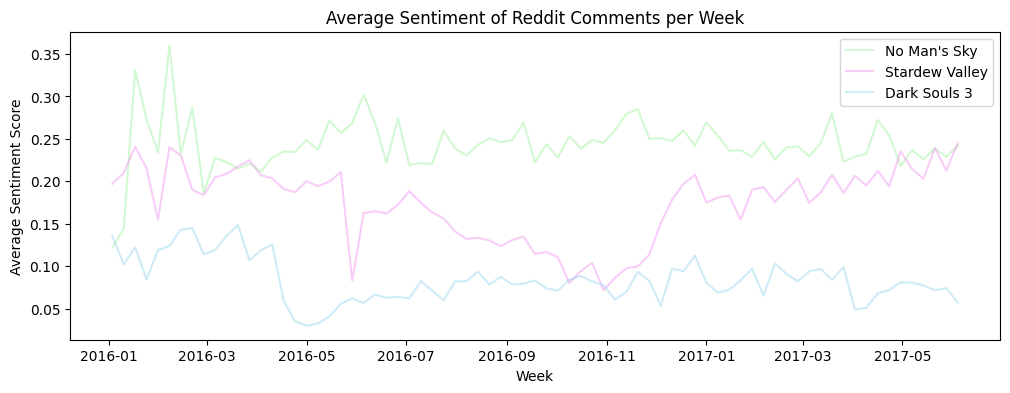

In [44]:
sentiments_list = [stardewvalley_c_sentiment, nomanssky_c_sentiment, darksouls3_c_sentiment]

plt.figure(figsize=(12,4))
for i in range(3):
    s = sentiments_list[i]
    s['created_utc'] = pd.to_datetime(s['created_utc'])
    plt.plot(s.groupby([pd.Grouper(key='created_utc', freq='W')])["compound"].mean(), color=colors[i], alpha=0.4)

plt.xlabel("Week")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment of Reddit Comments per Week")
plt.legend(labels=["No Man's Sky", "Stardew Valley", "Dark Souls 3"])
plt.show()

In [45]:
def clean_input_data(data, sentiment):
    data_group = data.groupby([pd.Grouper(key='created_utc', freq='D')])

    num_comments = data_group["id"].count()
    score = data_group["score"].mean()

    sentiment_group = sentiment.groupby([pd.Grouper(key='created_utc', freq='M')])
    sentiment_score = sentiment_group["compound"].mean()
    avg_length = sentiment_group["length"].mean()

    temp_df = pd.DataFrame({"num_comments": num_comments, "average_score":score, "sentiment":sentiment_score, "average_length": avg_length})
    temp_df['created_utc'] = pd.to_datetime(temp_df.index)
    temp_df.index = range(len(temp_df))
    temp_df = temp_df.fillna(0)
    # temp_df.index = temp_df.index.to_period('M').to_timestamp()
    return temp_df

stardewvalley_x = clean_input_data(stardewvalley_comments, stardewvalley_c_sentiment)
no_mans_sky_x = clean_input_data(nomanssky_comments, nomanssky_c_sentiment)
darksouls3_x = clean_input_data(darksouls3_comments, darksouls3_c_sentiment)

stardewvalley_c_data = pd.merge(stardewvalley_x, stardewvalley_y, left_on='created_utc', right_on='DateTime', how="inner")
stardewvalley_c_data = stardewvalley_c_data.drop(columns=["DateTime", "Average Players"])
nomanssky_c_data = pd.merge(no_mans_sky_x, nomanssky_y, left_on='created_utc', right_on='DateTime', how="inner")
nomanssky_c_data = nomanssky_c_data.drop(columns=["DateTime", "Average Players"])
darksouls3_c_data = pd.merge(darksouls3_x, darksouls3_y, left_on='created_utc', right_on='DateTime', how="inner")
darksouls3_c_data = darksouls3_c_data.drop(columns=["DateTime", "Average Players"])

Text(0.5, 1.0, 'Stardewvalley Correlation Heatmap')

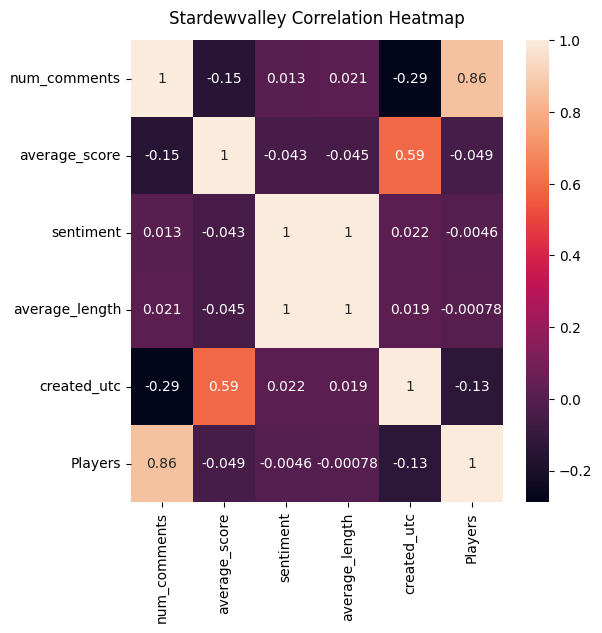

In [46]:
plt.figure(figsize=(6, 6))
stardewvalley_heatmap = sns.heatmap(stardewvalley_c_data.corr(), annot=True)
stardewvalley_heatmap.set_title('Stardewvalley Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Text(0.5, 1.0, 'No Mans Sky Correlation Heatmap')

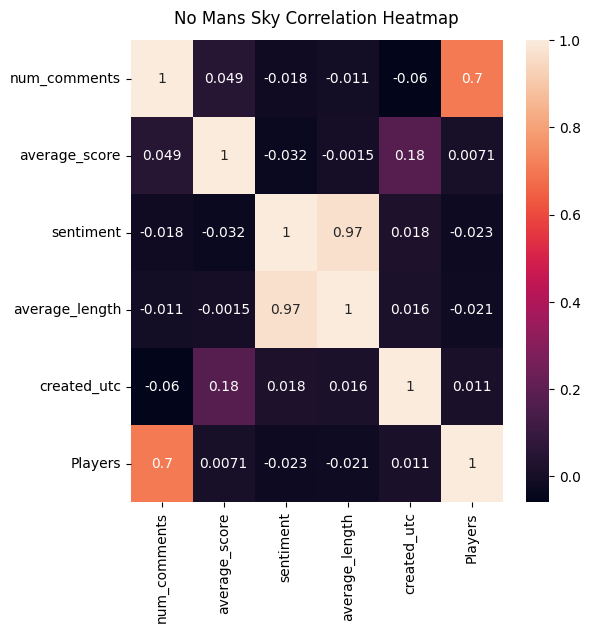

In [47]:
plt.figure(figsize=(6, 6))
no_mans_sky_heatmap = sns.heatmap(nomanssky_c_data.corr(), annot=True)
no_mans_sky_heatmap.set_title('No Mans Sky Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

Text(0.5, 1.0, 'Dark Souls 3 Correlation Heatmap')

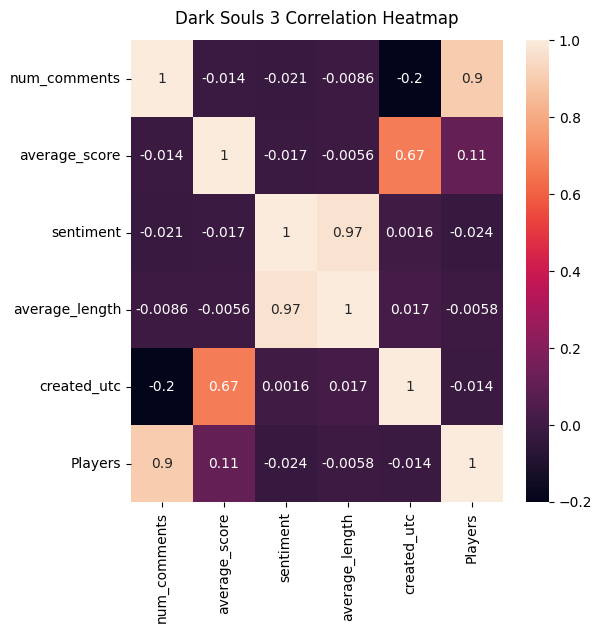

In [48]:
plt.figure(figsize=(6, 6))
darksouls3_heatmap = sns.heatmap(darksouls3_c_data.corr(), annot=True)
darksouls3_heatmap.set_title('Dark Souls 3 Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

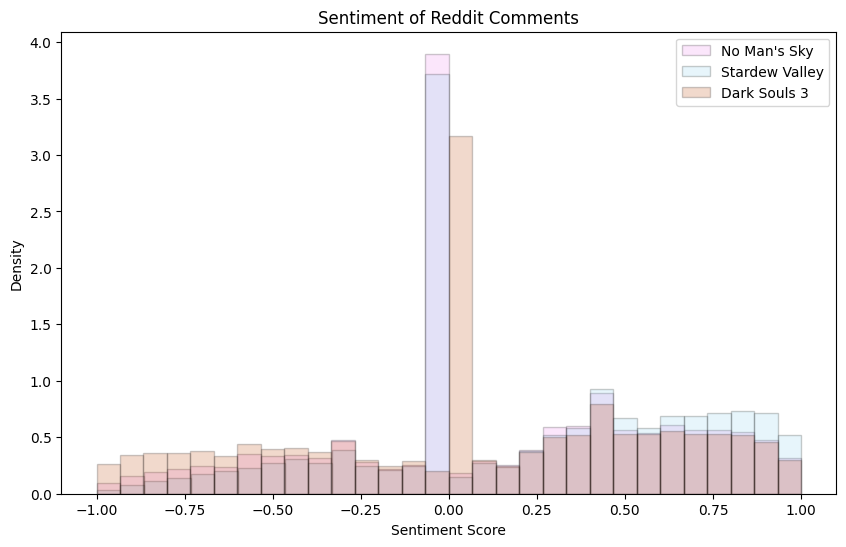

In [49]:
plt.figure(figsize=(10,6))

plt.hist(nomanssky_c_sentiment["compound"], bins=30, color = "violet", ec="black", alpha=0.2, density=True)
plt.hist(stardewvalley_c_sentiment["compound"], bins=30, color = "skyblue", ec="black", alpha=0.2, density=True)
plt.hist(darksouls3_c_sentiment["compound"], bins=30, color = "#bd4404", ec="black", alpha=0.2, density=True)

plt.xlabel("Sentiment Score")
plt.ylabel("Density")
plt.title("Sentiment of Reddit Comments")
plt.legend(labels=["No Man's Sky", "Stardew Valley", "Dark Souls 3"])
plt.show()


### Comment Modelling

In [50]:
default_models = [LinearRegression(), Ridge(), KNeighborsRegressor(),tree.DecisionTreeRegressor(), RandomForestRegressor()]

"""
Attempt various machine learning models and plot predicted values vs. true values of testing data set.
"""
def try_models(model_data, xcols, ycol, models=default_models):

    X = model_data[xcols]
    Y = model_data[ycol]

    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # 20-80 train test split data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    results = []
    mses = []

    fig, axs = plt.subplots(1, 5, figsize=(16,3))
    # fig.suptitle(ycol)
    fig.tight_layout(h_pad=5, w_pad=2)
    fig.subplots_adjust(top=0.88)

    for i, model in enumerate(models):
        t1 = time.time()
        model.fit(X_train, Y_train)
        results.append(model)

        # store the predictions for the training and test set
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        # calculate error
                # calculate error
        error = pred_test - Y_test
        mse = round(sum(error**2) / len(error), 2)

        print(model)

        print("Training R^2 :", model.score(X_train, Y_train))
        print("Testing MSE:", mse)

        # print("Test Accuracy: ", accuracy_score(Y_test, pred_test))
        # print("Training Accuracy: ", accuracy_score(Y_train, pred_train))
        r = 0
        c = i
        t2 = time.time()
        print("Time:", t2-t1)
        # axs[r, c].hist(Y_test, alpha=0.6)
        # axs[r, c].hist(pred_test, alpha=0.6)
        axs[c].grid()

        axs[c].scatter(pred_train, Y_train, alpha=0.3)
        axs[c].scatter(pred_test, Y_test, alpha=0.3)

        axs[c].set_xlabel("Predicted Value")
        axs[c].set_ylabel("Actual Value")
        axs[c].plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], linestyle="--", color="grey")
        axs[c].set_title(str(model) + "\n testing mse: " + str(mse))
        mses.append(mse)
        print()
    plt.savefig('try_models.png')
    plt.show()
    return results, mses

In [51]:
stardewvalley_c_data

,num_comments,average_score,sentiment,average_length,created_utc,Players
0,2,2.500000,0.000000,0.000000,2016-01-01,3.0
1,17,5.588235,0.000000,0.000000,2016-01-02,2.0
2,1,3.000000,0.000000,0.000000,2016-01-03,2.0
3,3,2.000000,0.000000,0.000000,2016-01-04,1.0
4,28,5.928571,0.000000,0.000000,2016-01-05,2.0
...,...,...,...,...,...,...
512,180,5.600000,0.000000,0.000000,2017-05-27,10114.0
513,199,7.708543,0.000000,0.000000,2017-05-28,10590.0
514,262,8.698473,0.000000,0.000000,2017-05-29,9828.0
515,337,6.732938,0.000000,0.000000,2017-05-30,9030.0


In [52]:
stardewvalley_data_cat = stardewvalley_c_data
stardewvalley_data_cat["subreddit"] = 0
nomanssky_data_cat = nomanssky_c_data
nomanssky_data_cat["subreddit"] = 1
darksouls3_data_cat = darksouls3_c_data
darksouls3_data_cat["subreddit"] = 2
all_c_data = pd.concat([stardewvalley_data_cat, nomanssky_data_cat, darksouls3_data_cat ])
all_c_data["created_utc"] = all_c_data["created_utc"].astype('int64')

Text(0.5, 1.0, 'All Games Correlation Heatmap')

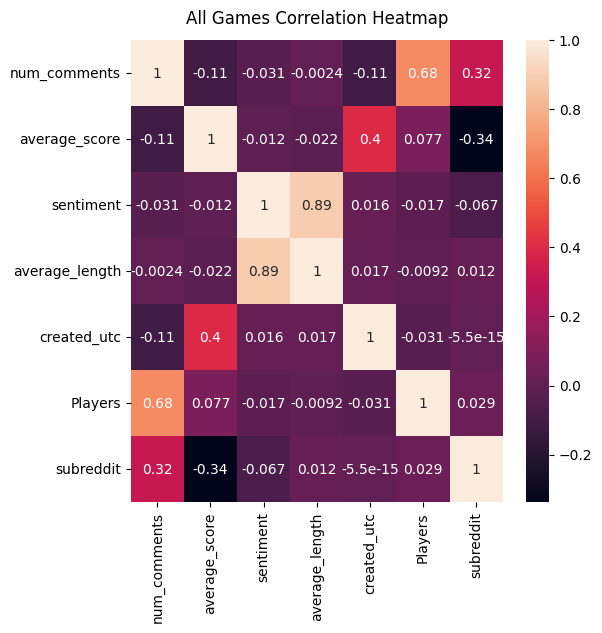

In [53]:
plt.figure(figsize=(6,6))
all_data_heatmap = sns.heatmap(all_c_data.corr(), annot=True)
all_data_heatmap.set_title('All Games Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

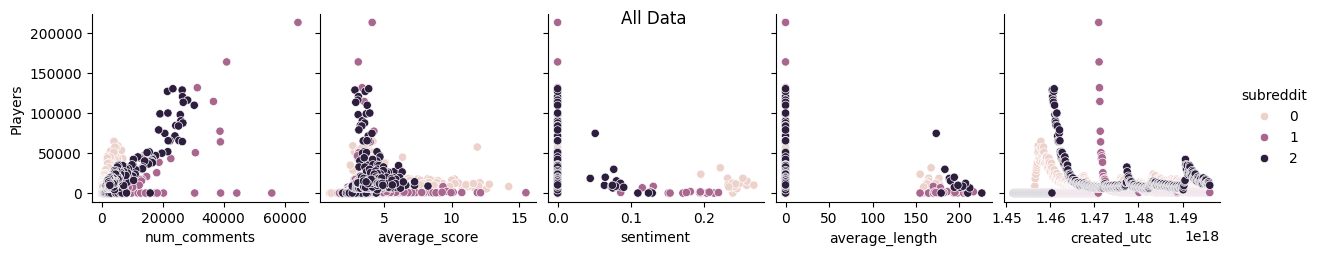

In [54]:
xcols = ['num_comments', 'average_score', 'sentiment',
       'average_length', 'created_utc']
ycol = 'Players'

sns.pairplot(data = all_c_data, x_vars = xcols, y_vars = ycol, hue="subreddit")
plt.suptitle("All Data")
plt.show()

LinearRegression()
Training R^2 : 0.4438706637965617
Testing MSE: 138881716.1
Time: 0.0076906681060791016

Ridge()
Training R^2 : 0.4438703024969153
Testing MSE: 138960930.67
Time: 0.006697893142700195

KNeighborsRegressor()
Training R^2 : 0.7712793898586203
Testing MSE: 150507572.08
Time: 0.025837182998657227

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 202236837.25
Time: 0.013596296310424805

RandomForestRegressor()
Training R^2 : 0.967861740267416
Testing MSE: 155706166.24
Time: 0.7137370109558105



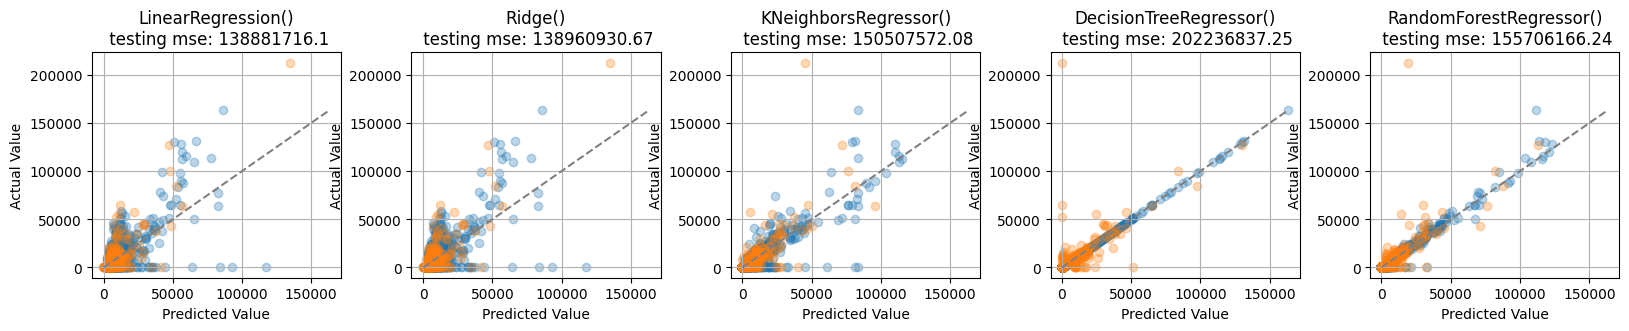

In [55]:
default_models = [LinearRegression(), Ridge(), KNeighborsRegressor(), tree.DecisionTreeRegressor(),
                  RandomForestRegressor()]
feature_importances = []

models, mses = try_models(all_c_data, xcols, ycol, default_models)

feature_importances.append(models[-1].feature_importances_)

LinearRegression()
Training R^2 : 0.7414583132055387
Testing MSE: 31750148.31
Time: 0.004621267318725586

Ridge()
Training R^2 : 0.7410638930423461
Testing MSE: 29429091.56
Time: 0.003952741622924805

KNeighborsRegressor()
Training R^2 : 0.8823233112874962
Testing MSE: 31481486.93
Time: 0.009809017181396484

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 16815472.06
Time: 0.006482839584350586

RandomForestRegressor()
Training R^2 : 0.9877738775958866
Testing MSE: 10852181.35
Time: 0.2738924026489258



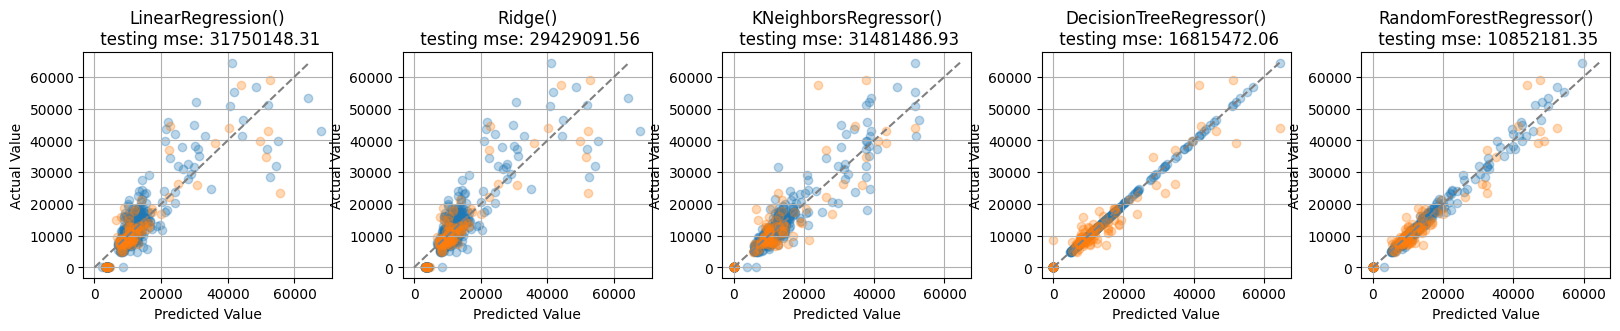

In [56]:
stardewvalley_mod_data = stardewvalley_c_data
stardewvalley_mod_data["created_utc"] = stardewvalley_mod_data["created_utc"].astype('int64')
stardewvalley_models, stardewvalley_mses = try_models(stardewvalley_mod_data, xcols, ycol, default_models)
feature_importances.append(stardewvalley_models[-1].feature_importances_)

LinearRegression()
Training R^2 : 0.47299961906816856
Testing MSE: 116216462.19
Time: 0.0042612552642822266

Ridge()
Training R^2 : 0.4729970312626165
Testing MSE: 116434755.15
Time: 0.004792928695678711

KNeighborsRegressor()
Training R^2 : 0.47636448289408406
Testing MSE: 140516020.65
Time: 0.009054422378540039

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 257127036.55
Time: 0.005300283432006836

RandomForestRegressor()
Training R^2 : 0.8911789018903861
Testing MSE: 90107892.83
Time: 0.2505488395690918



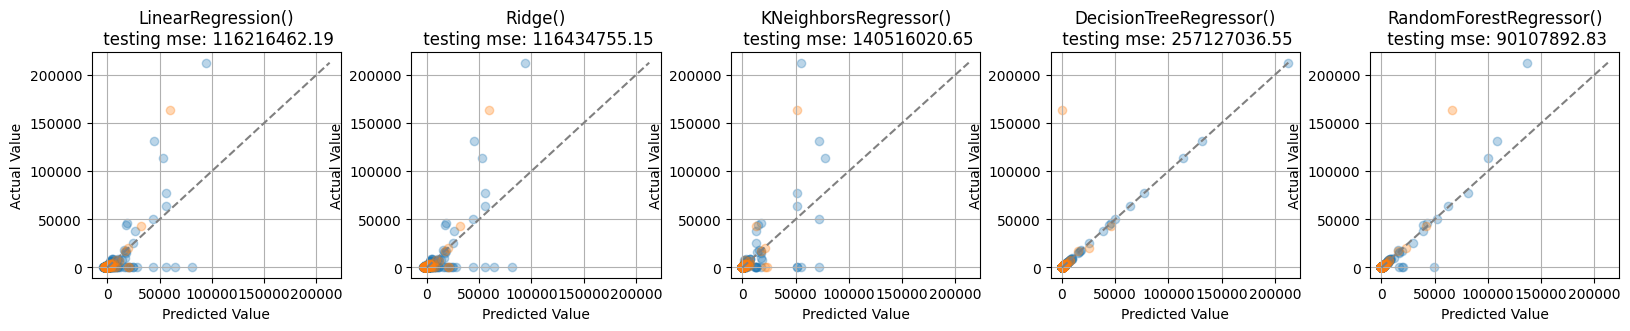

In [57]:
nomanssky_mod_data = nomanssky_c_data
nomanssky_mod_data["created_utc"] = nomanssky_mod_data["created_utc"].astype('int64')
nomanssky_models, nomanssky_mses = try_models(nomanssky_mod_data, xcols, ycol, default_models)
feature_importances.append(nomanssky_models[-1].feature_importances_)

LinearRegression()
Training R^2 : 0.8423599343135584
Testing MSE: 68345029.24
Time: 0.004159450531005859

Ridge()
Training R^2 : 0.8423533189543018
Testing MSE: 68399311.32
Time: 0.00412297248840332

KNeighborsRegressor()
Training R^2 : 0.9139775405503942
Testing MSE: 48606183.28
Time: 0.008819103240966797

DecisionTreeRegressor()
Training R^2 : 1.0
Testing MSE: 6121947.13
Time: 0.006474018096923828

RandomForestRegressor()
Training R^2 : 0.9930314110569517
Testing MSE: 7298795.94
Time: 0.27083587646484375



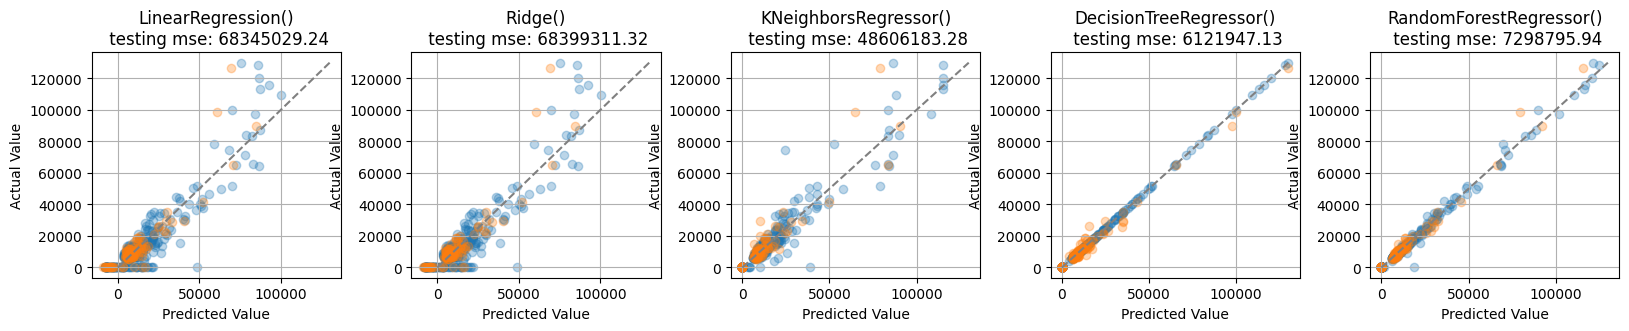

In [58]:
darksouls3_mod_data = darksouls3_c_data
darksouls3_mod_data["created_utc"] = darksouls3_mod_data["created_utc"].astype('int64')
darksouls3_models, darksouls3_mses = try_models(darksouls3_mod_data, xcols, ycol, default_models)
feature_importances.append(darksouls3_models[-1].feature_importances_)

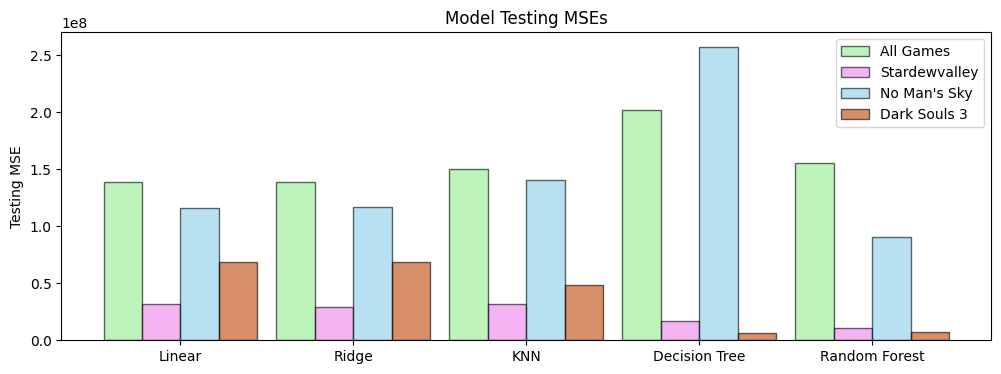

In [59]:
# Define the number of groups and the number of bars within each group
num_groups = 5
num_bars = 4

# Define the width of each bar and the locations of the bars within each group
bar_width = 0.2
group_width = num_bars * bar_width
group_spacing = 0.1
positions = np.arange(num_groups) * (group_width + group_spacing)

fig, ax = plt.subplots(figsize=(12, 4))
colors = ["lightgreen", 'violet', 'skyblue', '#bd4404']

for i, (label, mse) in enumerate(zip(["All Games", "Stardewvalley", "No Man's Sky", "Dark Souls 3"], [mses, stardewvalley_mses, nomanssky_mses, darksouls3_mses])):
    bar_positions = positions + i * bar_width
    ax.bar(bar_positions, mse, width=bar_width, label=label, alpha=0.6, color=colors[i], edgecolor="black")


ax.set_xticks(positions + (group_width - bar_width) / 2)
ax.set_xticklabels(["Linear", "Ridge", "KNN", "Decision Tree", "Random Forest"])

plt.ylabel("Testing MSE")
plt.title("Model Testing MSEs")

plt.legend()

plt.show()

### Analysing Random Forest results and feature importance for Comments


In [60]:
forrest_model = models[-1]

In [61]:
def test_model(model_data, xcols, ycol, model, max_depth=None, show=False):
    X = model_data[xcols]
    Y = model_data[ycol]

    # 20-80 train test split data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    t1 = time.time()
    model.fit(X_train, Y_train)

    # store the predictions for the training and test set
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    # calculate error
    error = pred_test - Y_test
    mse = sum(error**2) / len(error)
    test_accuracy = sum(np.round(pred_test) == Y_test) / len(Y_test)
    t2 = time.time()


    if(show):
        print("Testing MSE:", mse)
        print("Time: " + str(t2-t1))
        plt.hist(Y_test, alpha=0.9)
        plt.hist(pred_test, alpha=0.6)
        plt.title(ycol + " " + str(model) + "\n testing mse: " + str(mse) + "\n testing accuracy: " + str(test_accuracy) )
        plt.show()

    return [model, mse, test_accuracy]


def find_best_depth(model_data, xcols, ycol, min_depth = 3 , max_depth = 14, num_trees = 10, title=""):
    t1 = time.time()
    m_mse = []
    all_mse = []
    all_test = []
    for i in tqdm(range(min_depth, max_depth)):
        mses = []
        tests = []
        for j in range(num_trees):
            mResult = test_model(model_data, xcols, ycol, RandomForestRegressor(max_depth=i), show=False)
            mses.append(mResult[1])
            tests.append(mResult[2])
        all_mse.append(mses)
        all_test.append(tests)

    all_mse = np.array(all_mse)
    mean_mses = all_mse.mean(axis=1)
    min_mse = min(mean_mses)

    best_depth1 = min_depth + mean_mses.argmin()

    fig, axs = plt.subplots(1, 1, figsize=(16,5))

    axs.plot(list(range(min_depth, max_depth)), mean_mses)
    axs.fill_between(list(range(min_depth, max_depth)), all_mse.min(axis=1), all_mse.max(axis=1), alpha=0.2)
    axs.scatter(best_depth1, min_mse, color="blue")
    axs.set_xlabel("Tree Depth")
    axs.set_ylabel("Testing MSE")
    axs.set_title("{} (num_trees = {})".format(title, num_trees))

    plt.show()
    print("The best depth is {} with average testing MSE of {}".format(best_depth1, min_mse))
    t2 = time.time()
    print("Computation Time:" + str(t2-t1))

    return best_depth1

100%|██████████| 11/11 [00:46<00:00,  4.25s/it]


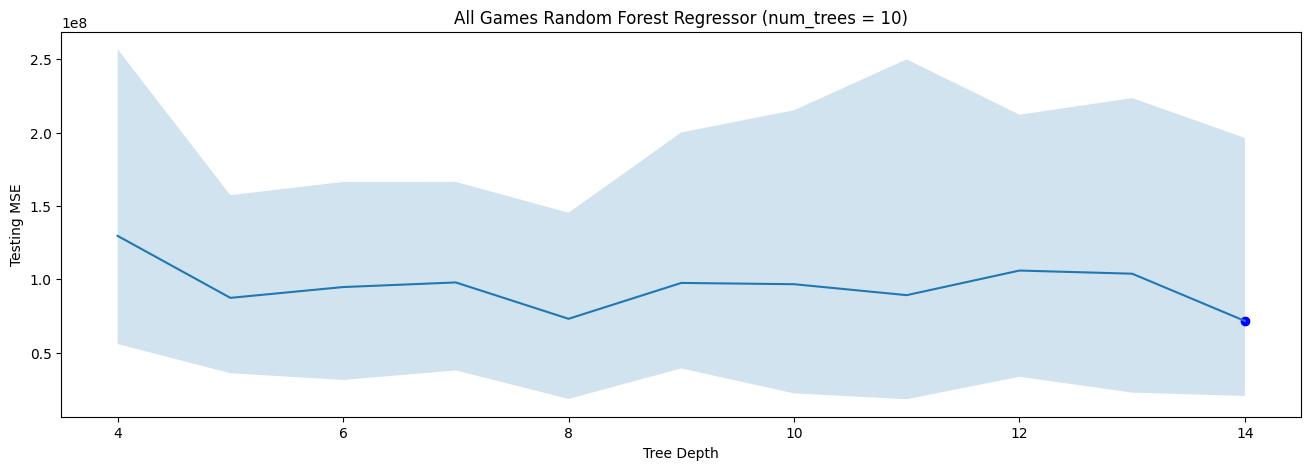

The best depth is 14 with average testing MSE of 71683048.30006048
Computation Time:47.05640769004822


In [62]:
best_depth = find_best_depth(all_c_data, xcols, ycol, min_depth = 4 , max_depth = 15, num_trees = 10, title="All Games Random Forest Regressor")

100%|██████████| 11/11 [00:24<00:00,  2.26s/it]


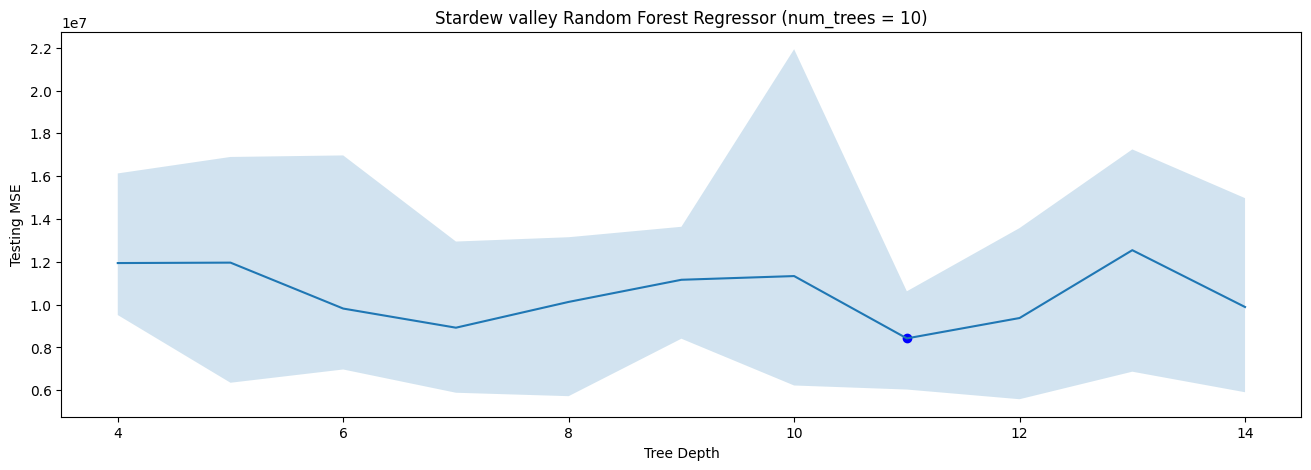

The best depth is 11 with average testing MSE of 8420978.35710198
Computation Time:25.17183780670166


In [63]:
stardewvalley_best_depth = find_best_depth(stardewvalley_c_data, xcols, ycol, min_depth = 4 , max_depth = 15, num_trees = 10, title="Stardew valley Random Forest Regressor")

100%|██████████| 11/11 [00:23<00:00,  2.13s/it]


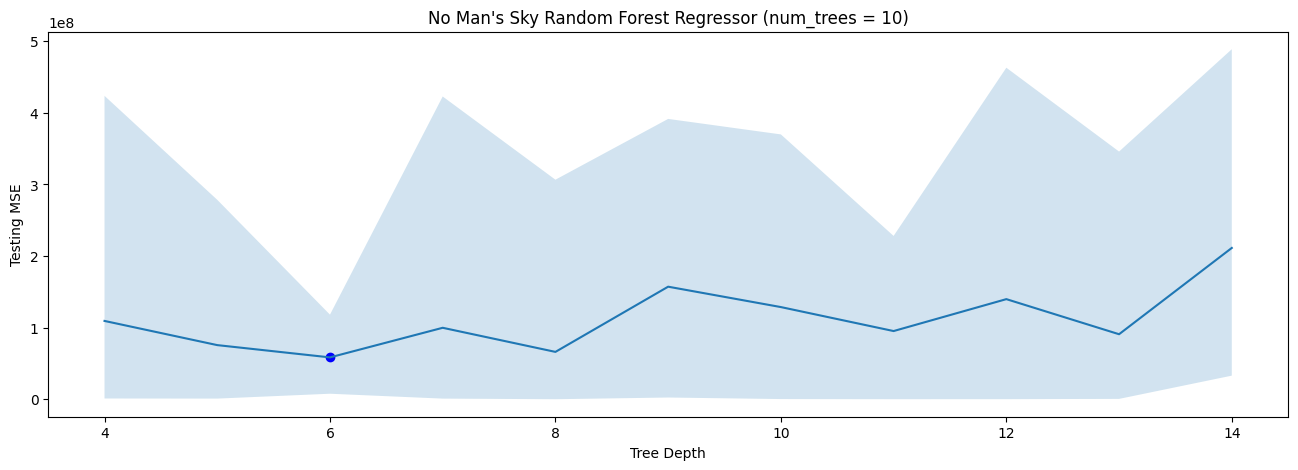

The best depth is 6 with average testing MSE of 58565225.416639425
Computation Time:23.711888313293457


In [64]:
no_mans_sky_best_depth = find_best_depth(nomanssky_c_data, xcols, ycol, min_depth = 4 , max_depth = 15, num_trees = 10, title="No Man's Sky Random Forest Regressor")

100%|██████████| 11/11 [00:24<00:00,  2.26s/it]


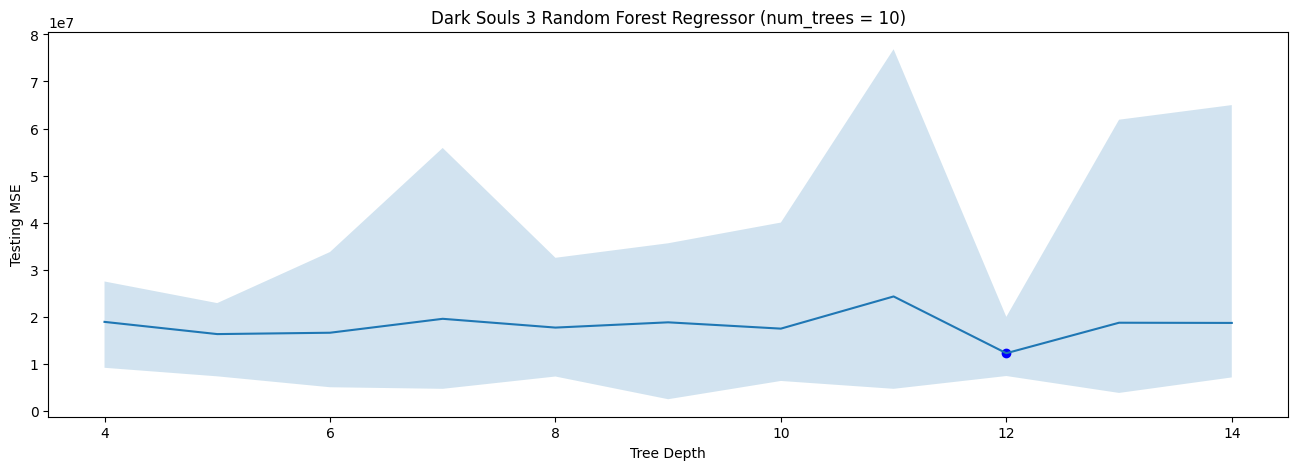

The best depth is 12 with average testing MSE of 12270904.061899235
Computation Time:25.189828395843506


In [65]:
darksouls3_best_depth = find_best_depth(darksouls3_c_data, xcols, ycol, min_depth = 4 , max_depth = 15, num_trees = 10, title="Dark Souls 3 Random Forest Regressor")

In [66]:
all_models = [models[-1], stardewvalley_models[-1], nomanssky_models[-1], darksouls3_models[-1]]
forest_importances = pd.Series(feature_importances[0], index=xcols)
forest_importances

num_comments      0.630822
average_score     0.110467
sentiment         0.000587
average_length    0.000400
created_utc       0.257724
dtype: float64

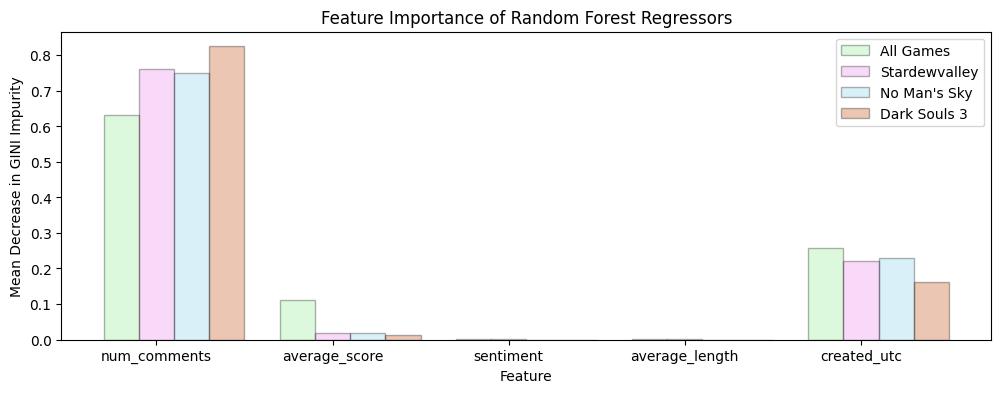

In [67]:
colors = ["lightgreen", 'violet', 'skyblue', '#bd4404']
labels = ["All Games", "Stardewvalley", "No Man's Sky", "Dark Souls 3"]

positions = np.array(list(range(len(xcols))))
bar_width = 0.2
plt.figure(figsize=(12, 4))

for i in range(4):
    plt.bar(positions + bar_width*(i-1), feature_importances[i], width=bar_width, label=label, alpha=0.3, color=colors[i], edgecolor="black")

plt.xticks(positions, labels=xcols)
plt.legend(labels=labels)
plt.xlabel("Feature")
plt.ylabel("Mean Decrease in GINI Impurity")
plt.title("Feature Importance of Random Forest Regressors")
plt.show()